<a href="https://colab.research.google.com/github/cutemfc/Time_series_project/blob/main/%E3%80%8CXGboost_Model_hyperparameter_tuning_ipynb%E3%80%8D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Step1. Load the data and import libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

In [ ]:
# Import the dataset and mount google drive
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
df_train_2014=pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/df_train_2014.csv')
df_train_2014.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion
0,24,105574,2013-01-02,18790.0,12.0,0.0
1,24,105574,2013-01-03,59692.0,1.0,0.0
2,24,105574,2013-01-04,99664.0,3.0,0.0
3,24,105574,2013-01-05,140805.0,4.0,0.0
4,24,105574,2013-01-06,182800.0,7.0,0.0


In [ ]:
df_train_2014.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion
0,24,105574,2013-01-02,18790.0,12.0,0.0
1,24,105574,2013-01-03,59692.0,1.0,0.0
2,24,105574,2013-01-04,99664.0,3.0,0.0
3,24,105574,2013-01-05,140805.0,4.0,0.0
4,24,105574,2013-01-06,182800.0,7.0,0.0


In [ ]:
df_train_2014.dtypes

,0
store_nbr,int64
item_nbr,int64
date,object
id,float64
unit_sales,float64
onpromotion,float64


In [ ]:
# dateframe the date and Filter the data before 2014-04-01
df_train_2014['date']=pd.to_datetime(df_train_2014['date'])
cutoff_date = pd.to_datetime('2014-04-01')
df_train = df_train_2014[df_train_2014['date'] < cutoff_date]




In [ ]:
df_train.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion
0,24,105574,2013-01-02,18790.0,12.0,0.0
1,24,105574,2013-01-03,59692.0,1.0,0.0
2,24,105574,2013-01-04,99664.0,3.0,0.0
3,24,105574,2013-01-05,140805.0,4.0,0.0
4,24,105574,2013-01-06,182800.0,7.0,0.0


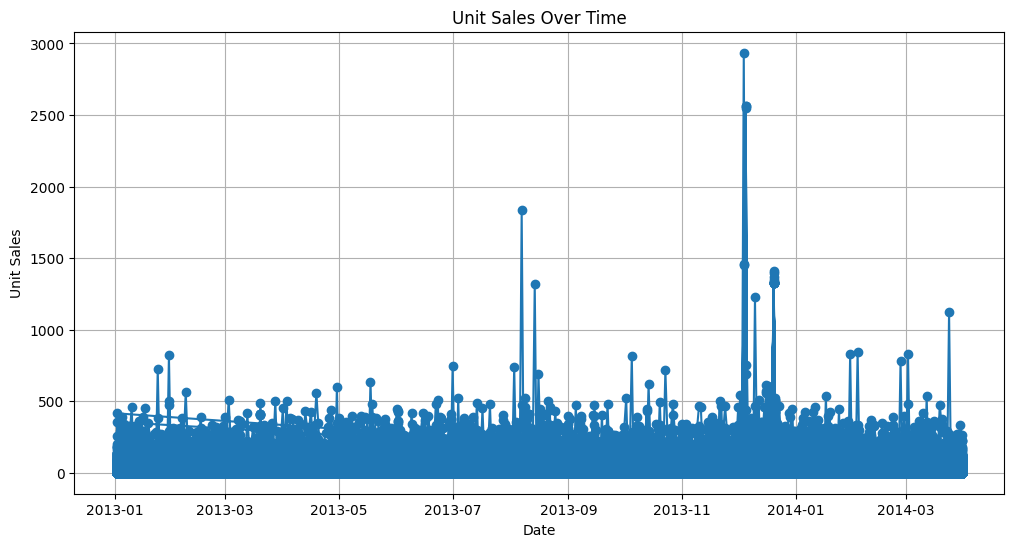

In [ ]:
# plot the sales unit and date line plot
plt.figure(figsize=(12,6))
plt.plot(df_train['date'],df_train['unit_sales'],marker='o',linestyle='-')
plt.title('Unit Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.grid(True)

In [ ]:
df_train.shape

(9437752, 6)

In [ ]:
df_train.shape

(9437752, 6)

In [ ]:
# Groupby by 'date' and aggregate 'unit_sales' by sum

df_train = df_train.groupby('date')['unit_sales'].sum().reset_index()
df_train.head()


,date,unit_sales
0,2013-01-02,42320.0
1,2013-01-03,32708.0
2,2013-01-04,30849.0
3,2013-01-05,42351.0
4,2013-01-06,43988.0


In [ ]:
# check the missing values
df_train.isnull().sum()

,0
date,0
unit_sales,0


# Feature Eingeering
(1) Creating Lag features

(2) Creating Rolling statistics

(3) Adding Date-based Features


In [ ]:
# create lag features
df_train['lag_1'] = df_train['unit_sales'].shift(1)
df_train['lag_7'] = df_train['unit_sales'].shift(7)
df_train['lag_30'] = df_train['unit_sales'].shift(30)

# Drop any rows with NaN values after creating lag features
df_train.dropna(inplace=True)
# Set date as index
df_train.set_index('date', inplace=True)

In [ ]:
df_train.head()

,unit_sales,lag_1,lag_7,lag_30
date,,,,
2013-02-01,36573.0,28619.0,30331.0,42320.0
2013-02-02,48688.0,36573.0,37643.0,32708.0
2013-02-03,46210.0,48688.0,38829.0,30849.0
2013-02-04,31774.0,46210.0,28117.0,42351.0
2013-02-05,30152.0,31774.0,26737.0,43988.0


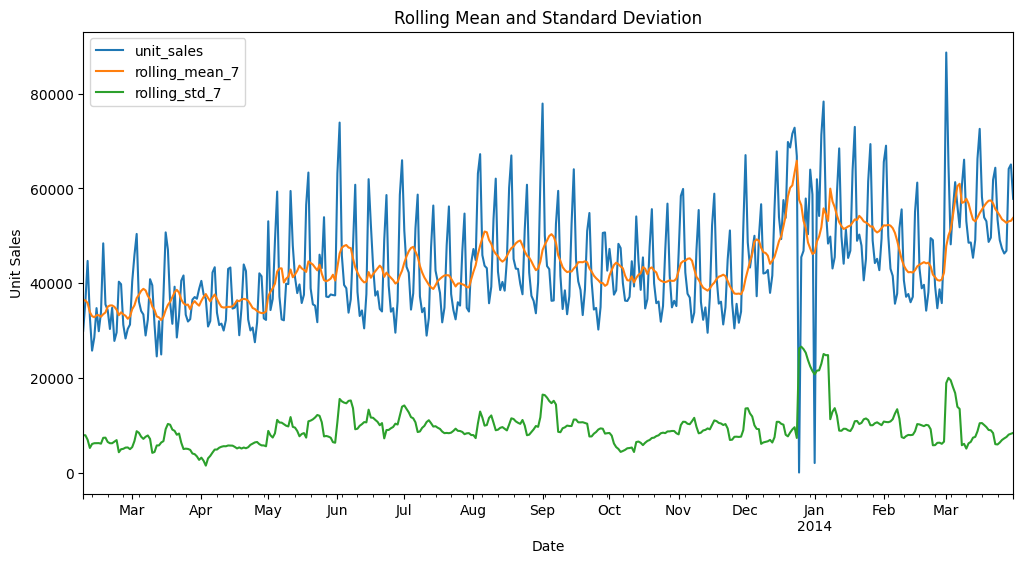

In [ ]:
# Creating Rolling Statistics
df_train['rolling_mean_7'] = df_train['unit_sales'].rolling(window=7).mean()
df_train['rolling_std_7'] = df_train['unit_sales'].rolling(window=7).std()
# Drop any NaN values afteer creating rolling features
df_train.dropna(inplace=True)

# Visualization the new featuress alongside the original sales
df_train[['unit_sales','rolling_mean_7','rolling_std_7']].plot(figsize=(12,6))
plt.title('Rolling Mean and Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.show()

In [ ]:
# add time based Features
df_train['year'] = df_train.index.year
df_train['month'] = df_train.index.month
df_train['day_of_week'] = df_train.index.dayofweek
df_train['is_weekend'] = df_train['day_of_week'].apply(lambda x:1 if x>=5 else 0)

In [ ]:
df_train.head()

,unit_sales,lag_1,lag_7,lag_30,rolling_mean_7,rolling_std_7,year,month,day_of_week,is_weekend
date,,,,,,,,,,
2013-02-07,29912.0,31686.0,28619.0,29607.0,36427.857143,7874.101651,2013,2,3,0
2013-02-08,36084.0,29912.0,36573.0,30738.0,36358.000000,7874.768483,2013,2,4,0
2013-02-09,44700.0,36084.0,48688.0,25853.0,35788.285714,6920.499927,2013,2,5,1
2013-02-10,32938.0,44700.0,46210.0,27865.0,33892.285714,5191.470624,2013,2,6,1
2013-02-11,25749.0,32938.0,31774.0,37915.0,33031.571429,6032.528045,2013,2,0,0


In [ ]:
df_train.shape

(418, 10)

# Split the data into Training and Testing data

In [ ]:
# Define target and features
X=df_train.drop(columns=['unit_sales'],axis=1)
y=df_train['unit_sales']


In [ ]:
# Split the data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,shuffle=False) # do not interrupt the order of data

# Hyperparameter of XGBoost

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

# Define the XGBoost regressor
xgb_model = XGBRegressor()


In [ ]:
# Define the parameter grid, try 3 values for each parameter
param_grid ={
    'eta': [0.01, 0.1, 0.3],
    'max_depth':[3,5,7],
    'subsample':[0.7,0.8,1.0],   # decide the fraction of data for each boosting to avoid the overfitting
    'colsample_bytree':[0.7,0.8,1.0], # decide the fraction of features to avoid overfitting
    'n_estimators':[100,200,300]
}

# Time series split for cross validation
tscv=TimeSeriesSplit(n_splits=5)
# Randomized search with cross-validation
random_search=RandomizedSearchCV(estimator=xgb_model,
                          param_distributions=param_grid,
                          cv=tscv,
                          n_iter=10,
                          scoring='neg_mean_squared_error')
# Fit the model and search the best hyperparameters
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params= random_search.best_params_
print('Best hyperparameters:', best_params)


Best hyperparameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'eta': 0.1, 'colsample_bytree': 1.0}


In [ ]:
#eta is equal to learing rate

#Implementing XGBoost for Time-Series Forecasting

In [ ]:
best_model=random_search.best_estimator_

In [ ]:


# Make predictions on the test set
y_pred=best_model.predict(X_test)

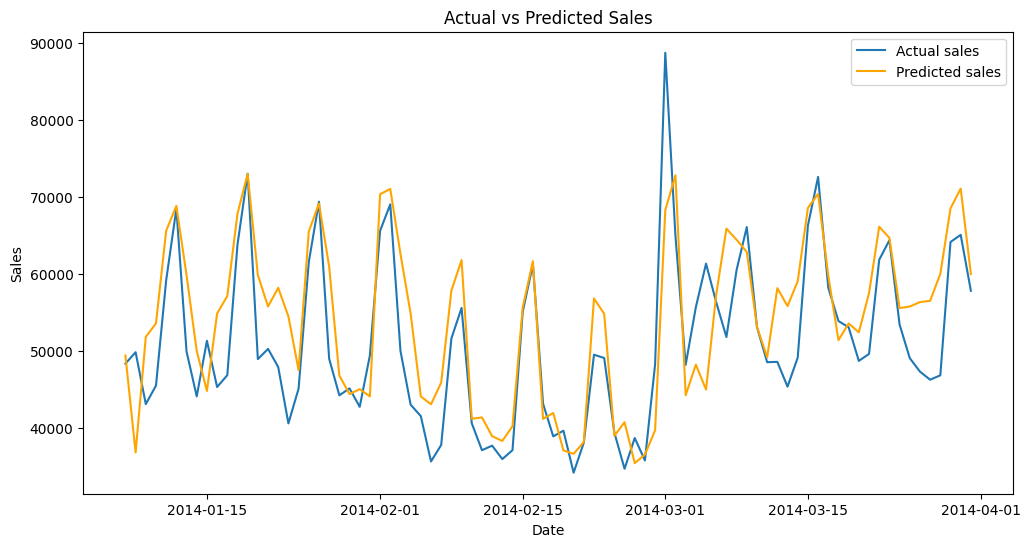

In [ ]:
# Plotting Actual vs Predicted Values
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test.values, label='Actual sales')
plt.plot(y_test.index, y_pred, label='Predicted sales', color='orange')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction.

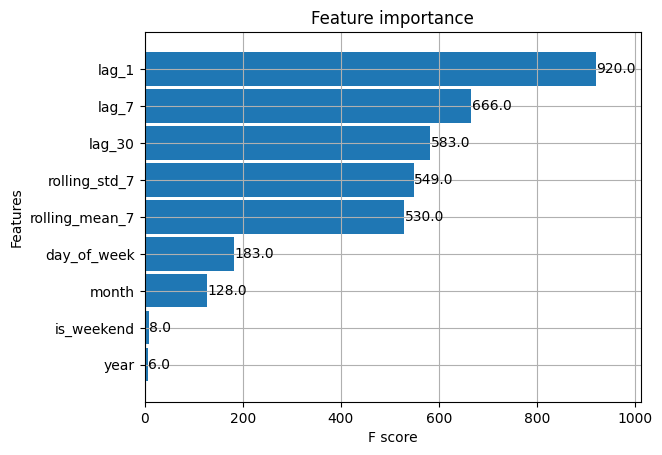

In [ ]:
# Feature Importance
plot_importance(xgboost_model, height=0.9);

In [ ]:
# Error metric of y_test and y_predict
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2 Score:', r2_score(y_test, y_pred))

Mean Absolute Error: 5455.175265625
Mean Squared Error: 49021470.70435332
Root Mean Squared Error: 7001.533453776631
R2 Score: 0.561912652672175


In [ ]:
def mean_absolute_percentage_error(y_test, y_pred):
    """Calculates MAPE given y_test and y_pred"""
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

In [ ]:
percent_error=mean_absolute_percentage_error(y_test,y_pred)
print('Mean Absolute of Percent Error:', percent_error)

Mean Absolute of Percent Error: 11.059042476149179


It is about 10% error

In [ ]:
# try to use the parameters that calculated by hyperaramters
xgboost_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8
)

In [ ]:
# train the XGBoost model
xgboost_model.fit(X_train,y_train)

# Make predictions on the test set
y_pred=xgboost_model.predict(X_test)

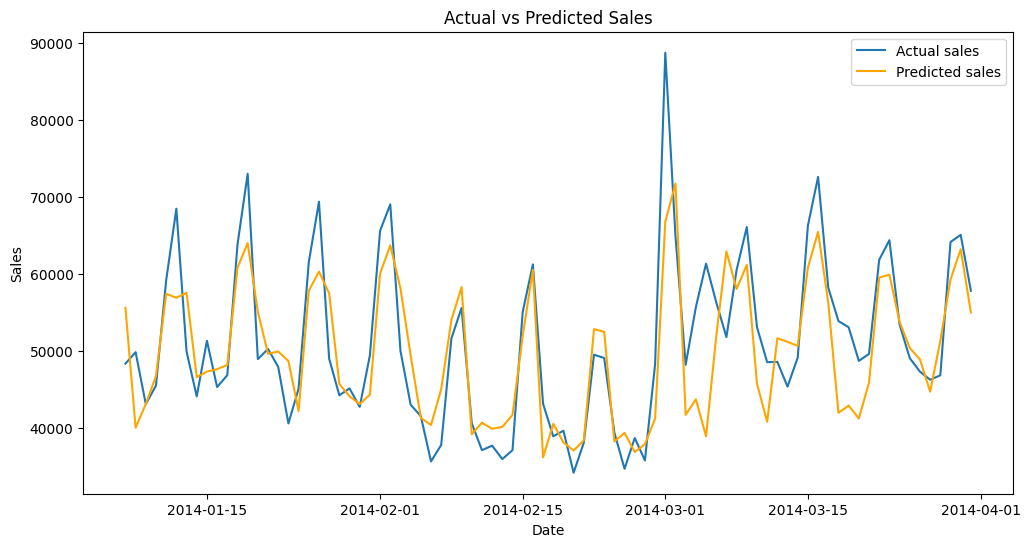

In [ ]:
# Plotting Actual vs Predicted Values
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test.values, label='Actual sales')
plt.plot(y_test.index, y_pred, label='Predicted sales', color='orange')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
# Error metric of y_test and y_predict
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2 Score:', r2_score(y_test, y_pred))

Mean Absolute Error: 4773.61732998512
Mean Squared Error: 39268150.427323446
Root Mean Squared Error: 6266.430437443908
R2 Score: 0.6490745869513777


In [ ]:
percent_error=mean_absolute_percentage_error(y_test,y_pred)
print('Mean Absolute of Percent Error:', percent_error)

Mean Absolute of Percent Error: 9.130777300111616


# Based on the tuning optimal paramters, all metric errors are reduced.
1.Improved the prediction accuracy: RMSE reduce from 7001 to 6266, it reduces the large preduction errors.

2.Inhaced Model Interpretability: r2 from 0.56 to 0.65, mape is from 11.0% to 9.13%, demonstrating a significant improvement to explain the variance in the data.

# How do we save the model

In [ ]:
import pickle
# define the path where are going to save the model
model_path='/content/drive/MyDrive/retail_kaggle_data/xgboost_model.pkl'

# saving oir xgboost_model model
with open(model_path, 'wb') as file:
    pickle.dump(xgboost_model, file)
print(f"Model saved as pickle file at:{model_path}")


Model saved as pickle file at:/content/drive/MyDrive/retail_kaggle_data/xgboost_model.pkl


In [ ]:
# open the
with open(model_path, 'rb') as file:
    loaded_model = pickle.load(file)

In [ ]:
y_pred=loaded_model.predict(X_test)

In [ ]:
print("R2:",r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R2: 0.6490745869513777
MSE: 39268150.427323446
